# CS 6787 PA2: Deep Learning
## Owner: Sikai Shen(ss2725)

# Summary

For this project assignment, I implemented neural network training in PyTorch. I worked with MNIST data and tested the effect of minibatch size, model architecture and optimizers on the performance of MNIST data over 5 epochs. The overall accuracy for the best model is more than 99%, which is surprisingly more than what I expected.

As for the coding part, I adapt my own work from the program assignment 3 of CS 5777 Large Scale ML course. There are 4 main functions in my code: load_MNIST_dataset(), construct_dataloaders(), evaluate_model(), and train(). The first 2 functions are used for loading MNIST data, training and validation split and control the minibatch size. evaluate_model() is used whenever we need to evaluate the loss and accuracy of a model over any dataset. train() is the main function where the training of the model happens. All of my models are created in sequential form since the forward function is direct.

# Code

## Import and Data loading

In [29]:
%matplotlib inline
import seaborn; seaborn.set_style('whitegrid')
import torch

%load_ext watermark
%watermark -n -m -p numpy,torch

The watermark extension is already loaded. To reload it, use:
  %reload_ext watermark
numpy: 1.26.4
torch: 2.2.1

Compiler    : Clang 14.0.6 
OS          : Darwin
Release     : 22.3.0
Machine     : x86_64
Processor   : i386
CPU cores   : 8
Architecture: 64bit



In [2]:
# Import management
import numpy as np
import copy
import matplotlib.pyplot as plt
from tqdm import tqdm

In [3]:
import torch
import torch.nn as nn
import torch.nn.functional as F
import torchvision
from torch.utils.data import DataLoader

In [4]:
# loading data
def load_MNIST_dataset():
    transform = torchvision.transforms.ToTensor()
    mnist_path = 'path/to/mnist/data'
    mnist_train = torchvision.datasets.MNIST(root=mnist_path, train=True, transform=transform, download=True)
    mnist_test = torchvision.datasets.MNIST(root=mnist_path, train=False, transform=transform)
    mnist_splitted_train, mnist_validation = torch.utils.data.random_split(
        mnist_train, [54000, 6000], generator=torch.Generator().manual_seed(42))
    return (mnist_train, mnist_test, mnist_splitted_train, mnist_validation)

In [5]:
# dataloaders for the MNIST dataset
def construct_dataloaders(dataset, batch_size, shuffle_train=True):
    train_dataset, test_dataset, splitted_train_dataset, validation_dataset = dataset
    train_dataloader = DataLoader(train_dataset,
                                batch_size = batch_size,
                                shuffle = shuffle_train,)
    test_dataloader = DataLoader(test_dataset,
                                batch_size = 100,
                                shuffle = False,)
    splitted_train_dataloader = DataLoader(splitted_train_dataset,
                                batch_size = batch_size,
                                shuffle = shuffle_train,)
    validation_dataloader = DataLoader(validation_dataset,
                                batch_size = 100,
                                shuffle = False,)

    dataloaders = {}
    dataloaders['train'] = train_dataloader
    dataloaders['test'] = test_dataloader
    dataloaders['splitted_train'] = splitted_train_dataloader
    dataloaders['validation'] = validation_dataloader
    return dataloaders

In [6]:
dataset = load_MNIST_dataset()
dataloaders = construct_dataloaders(dataset, 32, shuffle_train=True)
len(dataloaders['train'].dataset)

60000

In [7]:
# Pre-load dataloaders with batch size 32 and 8
dataloaders_32 = construct_dataloaders(dataset, 32, shuffle_train=True)
dataloaders_8 = construct_dataloaders(dataset, 8, shuffle_train=True)

## Part 1: LeNet - 5

### History of LeNet-5
LeNet-5 was first proposed by Yann LeCun, Léon Bottou, Yoshua Bengio, and Patrick Haffner in their seminal paper titled "Gradient-Based Learning Applied to Document Recognition." 

### Architecture of LeNet-5
**Input Layer**: The input layer is designed to take 32x32 pixel images. The paper assumes these inputs to be pre-processed images of handwritten digits.

**C1 - Convolutional Layer**: This layer has 6 feature maps and uses a 5x5 kernel for convolution, resulting in feature maps of size 28x28. Each unit in the feature maps is connected to a 5x5 neighborhood in the input. This layer introduces the concept of local receptive fields.

**S2 - Subsampling/Pooling Layer**: Follows C1 and is a pooling layer with 6 feature maps of size 14x14. It performs subsampling by 2, effectively reducing the dimensionality and introducing invariance to minor changes in the input.

**C3 - Convolutional Layer**: This layer contains 16 feature maps and uses a 5x5 kernel. The connections between S2 and C3 are not fully connected; instead, each unit in C3 is connected to several feature maps from S2, following a specific connection scheme designed to encourage feature diversity.

**S4 - Subsampling/Pooling Layer**: Similar to S2, this layer performs subsampling for the 16 feature maps from C3, resulting in feature maps of size 5x5.

**C5 - Fully Connected Convolutional Layer**: Although termed a convolutional layer, C5 is fully connected to the previous layer (S4). With 120 units, this layer can be seen as a fully connected layer since its 5x5 feature maps are fully connected to the 5x5 feature maps of S4, leaving 1x1 feature maps.

**F6 - Fully Connected Layer**: This is a standard fully connected layer with 84 units. It is designed to combine the features extracted by the previous layers.

**Output Layer**: The final layer uses a radial basis function (RBF) network for the output, which differs from the more commonly used softmax activation function in modern architectures. This layer is designed for classifying digits into one of 10 categories (0-9).

**Activation Functions**: The activation function used in LeNet-5's convolutional and fully connected layers is the sigmoid function. This choice reflects the common practice at the time of the network's development. The output layer uses radial basis functions for the classification task, which is a departure from the activation functions used in the rest of the network. However, the later implementation replace sigmoid with ReLu

### Expected Accuracy
In the original experiments with LeNet-5, Yann LeCun and his colleagues reported error rates. The best versions of LeNet-5 achieved error rates below 1% on the MNIST test set, which is equivalent to an accuracy of over 99%.

### Training Algo
LeNet-5 was trained using a form of gradient descent known as backpropagation, a fundamental technique for training neural networks. Specifically, the original LeNet-5 implementation utilized Stochastic Gradient Descent (SGD) with backpropagation to optimize the network's weights.

### Number of parameters
61706

In [8]:
# We can create LeNet-5 using nn.Sequential since the forward is straight
def make_lenet5_model():    
    LeNet5 = nn.Sequential(
        nn.Conv2d(1, 6, 5, padding=2),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(6, 16, 5),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(16*5*5, 120),
        nn.ReLU(),
        nn.Linear(120, 84),
        nn.ReLU(),
        nn.Linear(84, 10)
    )
    return LeNet5

In [9]:
def get_parameter_num(model, trainable = True):
    if trainable:
        num = sum(p.numel() for p in model.parameters() if p.requires_grad)
    else:
        num =  sum(p.numel() for p in model.parameters())
    return num

In [10]:
model = make_lenet5_model()
get_parameter_num(model)

61706

In [11]:
# We can also use a nn.Module implementation
class LeNet5(nn.Module):
    def __init__(self):
        super(LeNet5, self).__init__()
        self.conv1 = nn.Conv2d(1, 6, 5, padding=2)
        self.conv2 = nn.Conv2d(6, 16, 5)
        self.fc1   = nn.Linear(16*5*5, 120)
        self.fc2   = nn.Linear(120, 84)
        self.fc3   = nn.Linear(84, 10)

    def forward(self, x):
        x = F.max_pool2d(F.relu(self.conv1(x)), (2, 2))
        x = F.max_pool2d(F.relu(self.conv2(x)), (2, 2))
        x = x.view(-1, self.num_flat_features(x))
        x = F.relu(self.fc1(x))
        x = F.relu(self.fc2(x))
        x = self.fc3(x)
        return x

    def num_flat_features(self, x):
        size = x.size()[1:]  # all dimensions except the batch dimension
        num_features = 1
        for s in size:
            num_features *= s
        return num_features

In [12]:
model_lenet5 = LeNet5()
get_parameter_num(model_lenet5)

61706

## Part 2: Training a network

In [13]:
# A sequential implementation of the model
def make_model():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=32, out_channels=32, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(in_features=800, out_features=128),
        nn.ReLU(),
        nn.Linear(in_features=128, out_features=10)
    )
    return model

In [14]:
@torch.no_grad()
def evaluate_model(dataloader, model, loss_fn):
    loss, accuracy = 0, 0
    with torch.no_grad():
        for X, y in dataloader:
            y_hat = model(X)
            loss += loss_fn(y_hat, y).item()
            accuracy += (y_hat.argmax(1) == y).type(torch.float).sum().item()
    loss = loss / len(dataloader.dataset)
    accuracy = accuracy / len(dataloader.dataset)
    return (loss, accuracy)

In [15]:
def train(dataloaders, model, loss_fn, optimizer, epochs, require_validation=True):
    # Load all data as dataloaders
    if require_validation:
        train_dataloader = dataloaders['splitted_train']
        validation_dataloader = dataloaders['validation']
    else:
        train_dataloader = dataloaders['train']    
    test_dataloader = dataloaders['test']
    
    # Prepare all lose and error
    train_loss, train_acc, validation_acc = [], [], []
    result = {}
    
    # Evaluate the model before training
    model.train()
    model.eval()
    tr_loss, tr_accuracy = evaluate_model(train_dataloader, model, loss_fn)
    va_loss, va_accuracy = evaluate_model(validation_dataloader, model, loss_fn)
    train_loss.append(copy.deepcopy(tr_loss))
    train_acc.append(copy.deepcopy(tr_accuracy))
    validation_acc.append(copy.deepcopy(va_accuracy))
    
    # Training epochs
    for i in tqdm(range(epochs)):
        model.train()
        for X, y in train_dataloader:
            optimizer.zero_grad()
            y_hat = model(X)
            loss = loss_fn(y_hat, y)
            loss.backward()
            optimizer.step()
        
        # Evaluate the model after each epoch
        model.eval()   
        tr_loss, tr_accuracy = evaluate_model(train_dataloader, model, loss_fn)
        va_loss, va_accuracy = evaluate_model(validation_dataloader, model, loss_fn)
        train_loss.append(copy.deepcopy(tr_loss))
        train_acc.append(copy.deepcopy(tr_accuracy))
        validation_acc.append(copy.deepcopy(va_accuracy))
        
    # Collect final results    
    result['train_loss'] = train_loss
    result['train_accuracy'] = train_acc
    result['validation_accuracy'] = validation_acc

    return model, result

In [16]:
model = make_model()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.99)
epochs = 5
model, result = train(dataloaders_32, model, loss_fn, optimizer, epochs, require_validation=True)

100%|█████████████████████████████████████████████| 5/5 [03:08<00:00, 37.67s/it]


### Wall-clock time

For 5 epochs of training on the base model, the approximate training time is 190 seconds

In [17]:
def plot_model_performance(result, num_epoch):
    # Creating subplots for each performance metric
    fig, axs = plt.subplots(1, 3, figsize=(18, 6))
    epochs = range(num_epoch+1)
    def add_value_labels(ax, data_points):
        for i, value in enumerate(data_points):
            ax.text(i, value, f"{value:.6f}", ha='center', va='bottom')
            
    # Train Loss
    axs[0].plot(epochs, result['train_loss'], marker='o', color='tab:red', label='Train Loss')
    axs[0].set_title('Train Loss Over Epochs')
    axs[0].set_xlabel('Epoch')
    axs[0].set_ylabel('Train Loss')
    axs[0].set_xticks(epochs)
    axs[0].grid(True)
    add_value_labels(axs[0], result['train_loss'])
    axs[0].legend()
    
    # Train Accuracy
    axs[1].plot(epochs, result['train_accuracy'], marker='s', color='tab:blue', label='Train Accuracy')
    axs[1].set_title('Train Accuracy Over Epochs')
    axs[1].set_xlabel('Epoch')
    axs[1].set_ylabel('Train Accuracy')
    axs[1].set_xticks(epochs)
    axs[1].grid(True)
    add_value_labels(axs[1], result['train_accuracy'])
    axs[1].legend()
    
    # Validation Accuracy
    axs[2].plot(epochs, result['validation_accuracy'], marker='^', color='tab:green', label='Validation Accuracy')
    axs[2].set_title('Validation Accuracy Over Epochs')
    axs[2].set_xlabel('Epoch')
    axs[2].set_ylabel('Validation Accuracy')
    axs[2].set_xticks(epochs)
    axs[2].grid(True)
    add_value_labels(axs[2], result['validation_accuracy'])
    axs[2].legend()
    
    plt.tight_layout()
    plt.show()

### Plot for base model performance

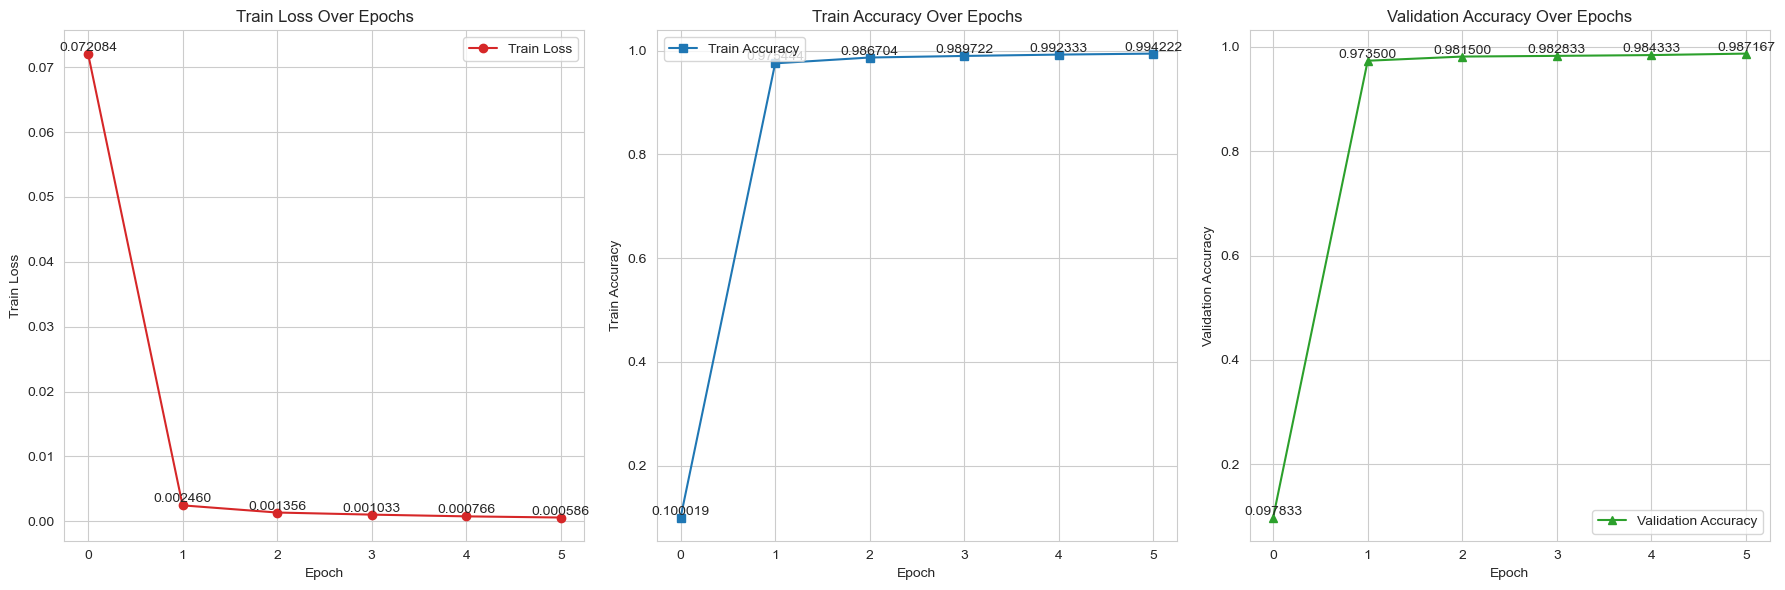

In [18]:
plot_model_performance(result, num_epoch = 5)

## Part 3: The effect of changing the minibatch size

### Hypothesis

For smaller minibatch size, I think the accuracy will be approximately the same because the performance of base model is really good and I don't think minibatch size can improve or affect the performance that much. For wall-clock time, I think the training time would be longer because it has 4x gradient updates.

In [19]:
model = make_model()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.99)
epochs = 5
model, result = train(dataloaders_8, model, loss_fn, optimizer, epochs, require_validation=True)

100%|█████████████████████████████████████████████| 5/5 [05:22<00:00, 64.45s/it]


### Wall-clock time

For 5 epochs of training on the model with batch size 8, the approximate training time is 320 seconds. It's about 1.7x more compared to the base model

### Plot for model with batch size 8 performance

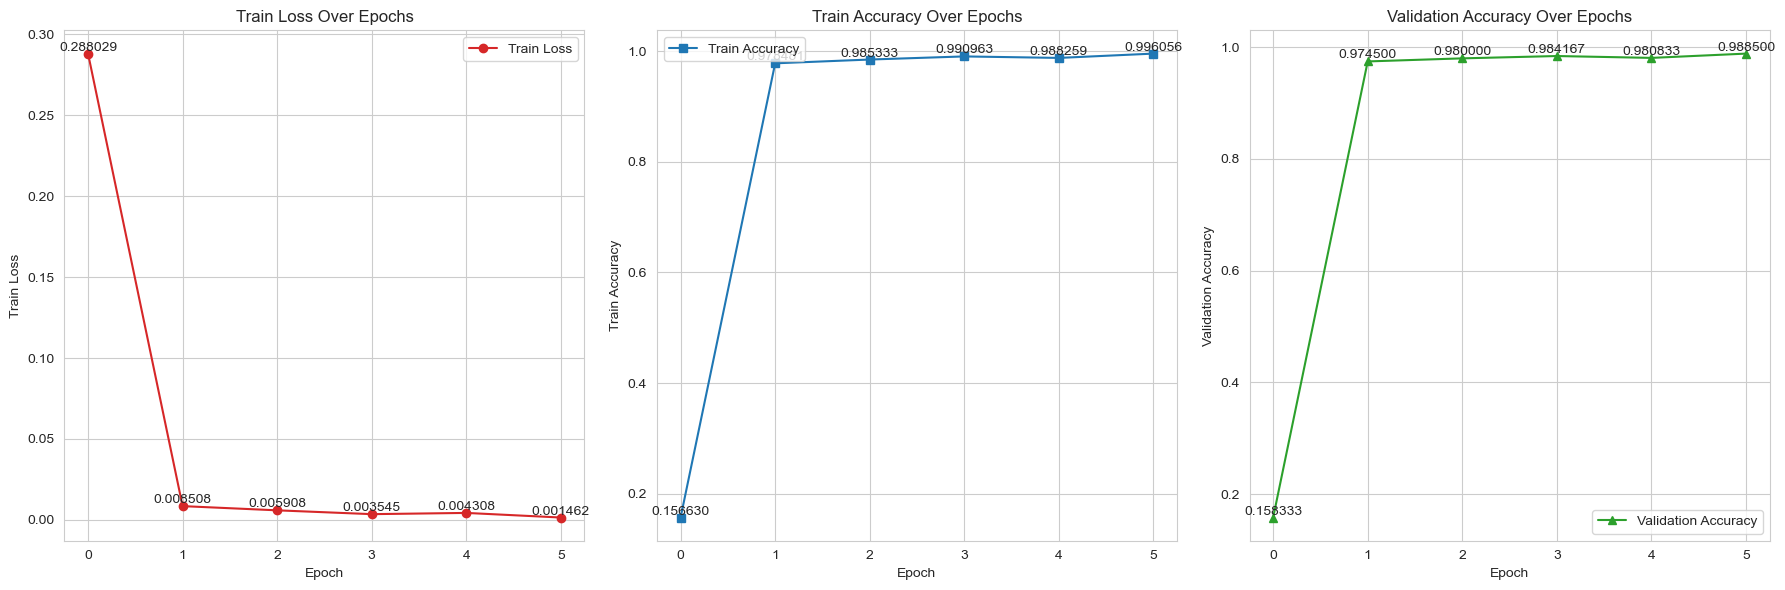

In [20]:
plot_model_performance(result, num_epoch = 5)

### Conclusion

My hypotheses are validated. The training loss is higher, but the accuracy on train and validation datasets are better. The training takes 1.7x more time compared to the base model so it's a lot slower compared to the base.

## Part 4: The effect of momentum

### Hypothesis

For plain SGD, I think the accuracy will decrease because the 5 epochs is not good enough for plain SGD to converge to a optimal model. For wall-clock time, I think the training time would be approximately the same as base model since the computational work is approximately the same

In [21]:
model = make_model()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001)
epochs = 5
model, result = train(dataloaders_32, model, loss_fn, optimizer, epochs, require_validation=True)

100%|█████████████████████████████████████████████| 5/5 [03:09<00:00, 37.81s/it]


### Wall-clock time

For 5 epochs of training on the model with plain SGD, the approximate training time is 190 seconds. It's almost same as the base model

### Plot for plain SGD model performance

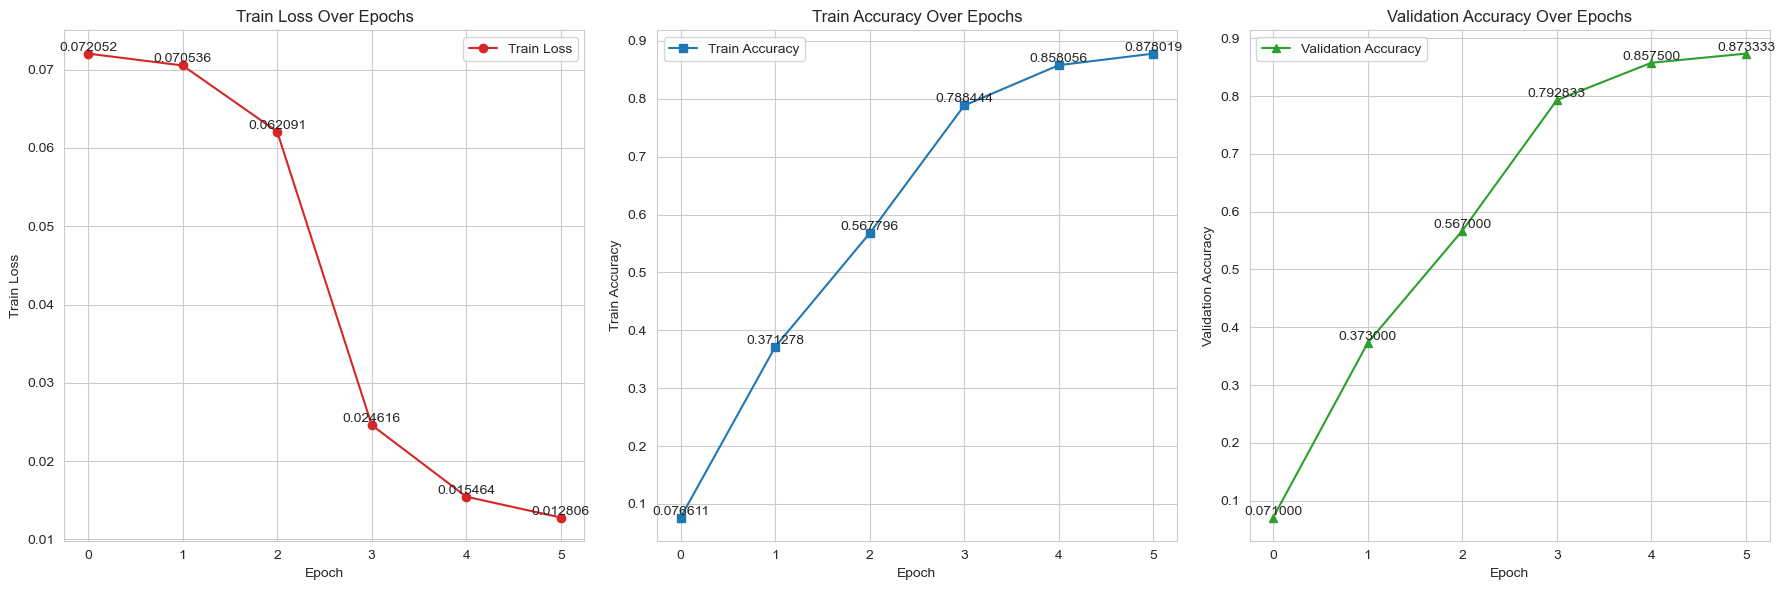

In [22]:
plot_model_performance(result, num_epoch = 5)

### Conclusion

My hypotheses are validated. The plain SGD only has 37% of accuracy after 1 epoch, while the base model can achieve 99% for just 1 epoch. The training time is approximately same as the base model

## Part 5: The effect of network size

### Hypothesis

For larger network, I think the accuracy will increase slightly since you have a larger model. For wall-clock time, I think the training time would be longer because it has more trainable parameters.

In [23]:
# A sequential implementation of the model
def make_model_2():
    model = nn.Sequential(
        nn.Conv2d(in_channels=1, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Conv2d(in_channels=64, out_channels=64, kernel_size=3),
        nn.ReLU(),
        nn.MaxPool2d(kernel_size=2, stride=2),
        nn.Flatten(),
        nn.Linear(in_features=1600, out_features=256),
        nn.ReLU(),
        nn.Linear(in_features=256, out_features=10)
    )
    return model

In [24]:
model = make_model_2()
loss_fn = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.SGD(model.parameters(), lr = 0.001, momentum = 0.99)
epochs = 5
model, result = train(dataloaders_32, model, loss_fn, optimizer, epochs, require_validation=True)

100%|█████████████████████████████████████████████| 5/5 [05:08<00:00, 61.64s/it]


### Wall-clock time

For 5 epochs of training on the model with larger network size, the approximate training time is 310 seconds. It's about 1.7x more compared to the base model

### Plot for larger model performance

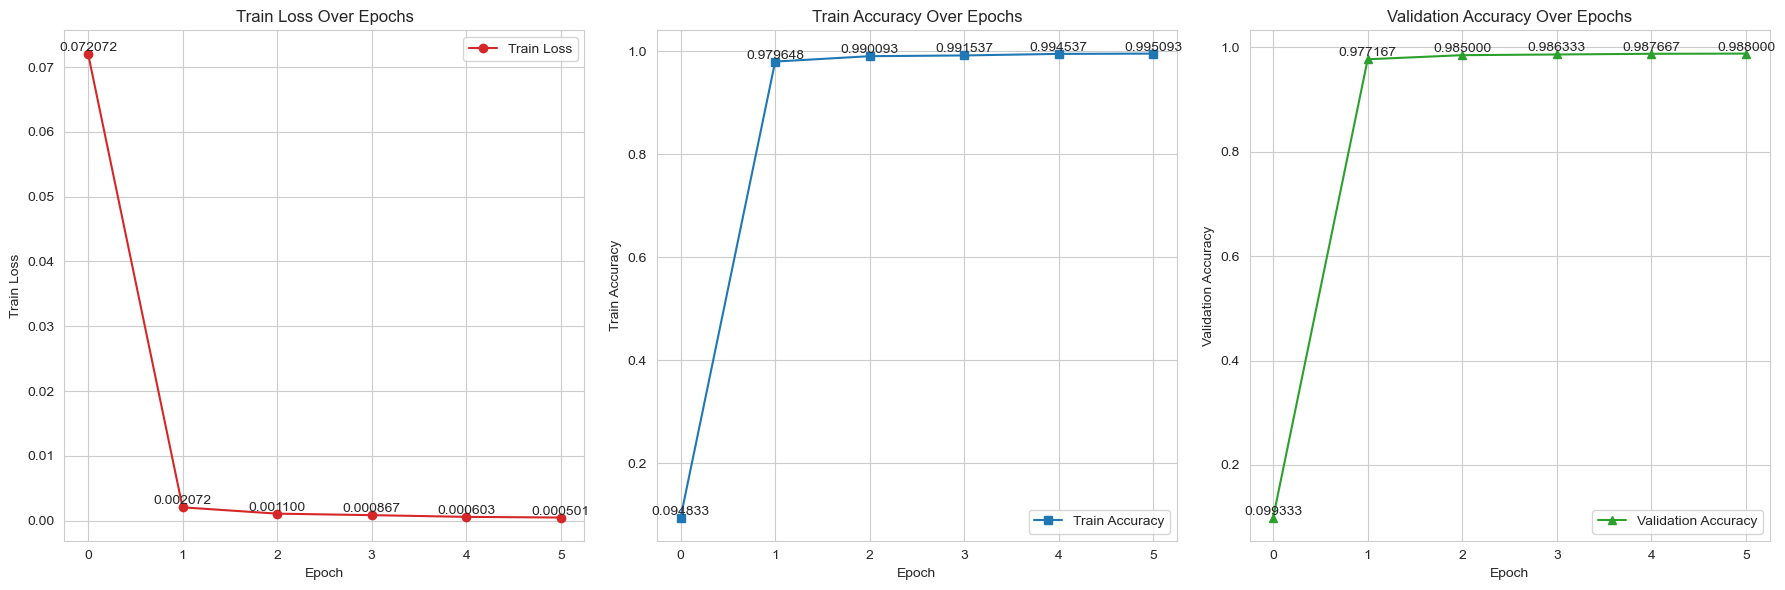

In [25]:
plot_model_performance(result, num_epoch = 5)

### Conclusion

My hypotheses are validated. A larger model has a lower train loss and better accuracy in bath training and validation datasets. The training takes 1.7x more time compared to the base model so it's a lot slower compared to the base.

## Part 6: Testing other optimizers

In [26]:
model = make_model()
optimizer_Adam_1 = torch.optim.Adam(model.parameters(), lr=0.001, betas=(0.99, 0.999))
loss_fn = torch.nn.CrossEntropyLoss()
epochs = 5
model, result = train(dataloaders_32, model, loss_fn, optimizer_Adam_1, epochs, require_validation=True)

100%|█████████████████████████████████████████████| 5/5 [03:02<00:00, 36.53s/it]


### Wall-clock time

For 5 epochs of training on the model with Adam, the approximate training time is 180 seconds, which is slightly faster base model

### Plot for Adam model performance

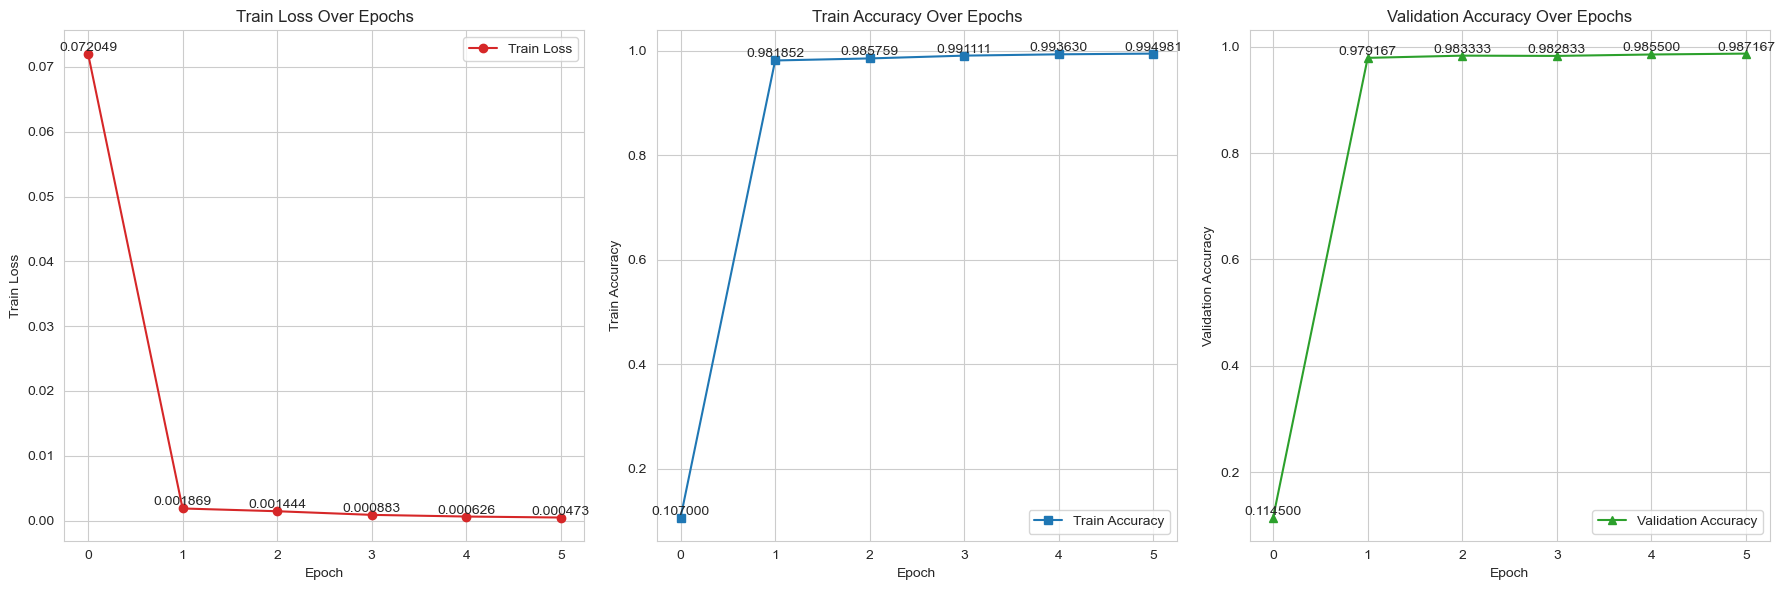

In [27]:
plot_model_performance(result, num_epoch = 5)